In [1]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

import seaborn as sns

%load_ext autoreload
%autoreload 2


Bad key savefig.frameon in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or

In [5]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

# import data

In [19]:
band_score = np.load('./data/band_score.npy')
grid_score = np.load('./data/grid_score.npy')
activations = np.load('./data/activations.npy')
phase = np.load('./data/phase.npy') # 相位
L = np.load('./data/L.npy') # 周期
J = np.load('./data/J_matrix.npy') # 位置

# grid score

(array([ 22.,  47.,  80.,  98., 475., 122., 126., 108., 211., 354., 301.,
        247., 174., 160., 166., 144., 182., 142., 164., 135., 116., 134.,
        108.,  84.,  79.,  66.,  33.,  13.,   4.,   1.]),
 array([-0.29889925, -0.2370673 , -0.17523536, -0.11340341, -0.05157146,
         0.01026049,  0.07209244,  0.13392439,  0.19575634,  0.25758829,
         0.31942023,  0.38125218,  0.44308413,  0.50491608,  0.56674803,
         0.62857998,  0.69041193,  0.75224388,  0.81407582,  0.87590777,
         0.93773972,  0.99957167,  1.06140362,  1.12323557,  1.18506752,
         1.24689946,  1.30873141,  1.37056336,  1.43239531,  1.49422726,
         1.55605921]),
 <BarContainer object of 30 artists>)

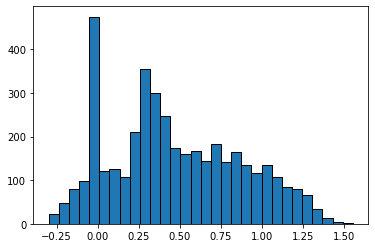

In [3]:
plt.hist(grid_score, bins=30, edgecolor='black')

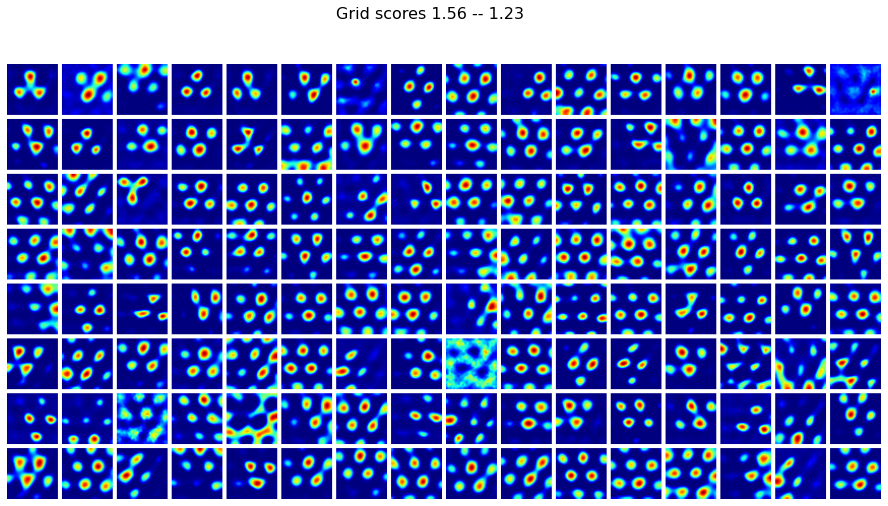

In [11]:
from visualize import compute_ratemaps, plot_ratemaps

idxs = np.flip(np.argsort(grid_score))
Ng = 4096

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16, 4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(grid_score[idxs[0]], 2))
             +' -- '+ str(np.round(grid_score[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# band to grid


In [15]:
high_band_idxs = np.where(band_score > 8.0)[0]

# L在左边的低频区域的band
band_L_low_idx = np.where((L > 0) & (L < 1.4))[0]
band_idx_ = np.intersect1d(band_L_low_idx, high_band_idxs)
band_idx = band_idx_[np.argsort(phase[band_idx_])]
band_idx.shape

(372,)

In [17]:
# 挑选grid cell
grid_idx = np.where(np.asarray(grid_score) > 1.2)[0]
print('selected cell number:', grid_idx.shape[0])

selected cell number: 177


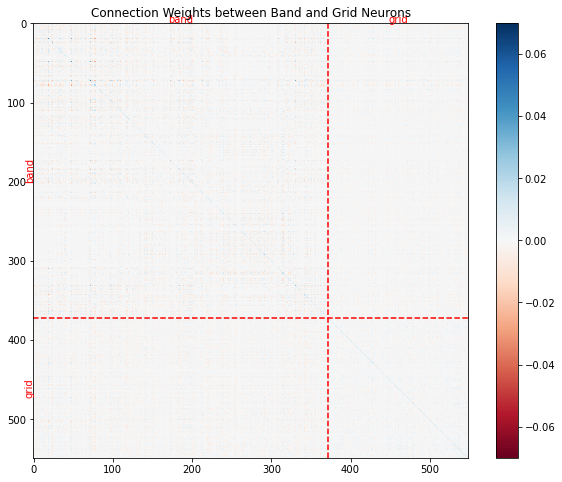

In [20]:
# 可视化band_idx和grid_idx之间的连接权重
# Combine band and grid indices
combined_idx = np.concatenate((band_idx, grid_idx))

# Extract weights for combined indices
band_grid_weights = J[combined_idx][:, combined_idx]

plt.figure(figsize=(10, 8))
plt.imshow(band_grid_weights, cmap='RdBu', vmin=-np.max(np.abs(band_grid_weights)), vmax=np.max(np.abs(band_grid_weights)))
plt.colorbar()
plt.title('Connection Weights between Band and Grid Neurons')

# 标出横纵轴中band和grid对应的区域
band_len = len(band_idx)
grid_len = len(grid_idx)

# 横轴标出band区域
plt.axvline(x=band_len, color='red', linestyle='--')
# 纵轴标出band区域
plt.axhline(y=band_len, color='red', linestyle='--')

# 在横轴标上band和grid
plt.text(band_len / 2, -5, 'band', ha='center', va='center', color='red')
plt.text(band_len + grid_len / 2, -5, 'grid', ha='center', va='center', color='red')

# 在纵轴标上band和grid
plt.text(-5, band_len / 2, 'band', ha='center', va='center', color='red', rotation=90)
plt.text(-5, band_len + grid_len / 2, 'grid', ha='center', va='center', color='red', rotation=90)

plt.show()

In [21]:
# Calculate the average absolute connection weights for the four regions
band_to_band_mean = np.mean(np.abs(J[band_idx][:, band_idx]))
grid_to_grid_mean = np.mean(np.abs(J[grid_idx][:, grid_idx]))
band_to_grid_mean = np.mean(np.abs(J[band_idx][:, grid_idx]))
grid_to_band_mean = np.mean(np.abs(J[grid_idx][:, band_idx]))

print("Band to Band Absolute Connection Weights Mean:", band_to_band_mean)
print("Grid to Grid Absolute Connection Weights Mean:", grid_to_grid_mean)
print("Band to Grid Absolute Connection Weights Mean:", band_to_grid_mean)
print("Grid to Band Absolute Connection Weights Mean:", grid_to_band_mean)

Band to Band Absolute Connection Weights Mean: 0.0027528442
Grid to Grid Absolute Connection Weights Mean: 0.002061689
Band to Grid Absolute Connection Weights Mean: 0.0017936018
Grid to Band Absolute Connection Weights Mean: 0.0025926903


In [22]:
# Calculate the average positive connection weights for the four regions
band_to_band_mean = np.mean(J[band_idx][:, band_idx][J[band_idx][:, band_idx] > 0])
grid_to_grid_mean = np.mean(J[grid_idx][:, grid_idx][J[grid_idx][:, grid_idx] > 0])
band_to_grid_mean = np.mean(J[band_idx][:, grid_idx][J[band_idx][:, grid_idx] > 0])
grid_to_band_mean = np.mean(J[grid_idx][:, band_idx][J[grid_idx][:, band_idx] > 0])

print("Band to Band Positive Connection Weights Mean:", band_to_band_mean)
print("Grid to Grid Positive Connection Weights Mean:", grid_to_grid_mean)
print("Band to Grid Positive Connection Weights Mean:", band_to_grid_mean)
print("Grid to Band Positive Connection Weights Mean:", grid_to_band_mean)

Band to Band Positive Connection Weights Mean: 0.0027749385
Grid to Grid Positive Connection Weights Mean: 0.0023753804
Band to Grid Positive Connection Weights Mean: 0.0018201234
Grid to Band Positive Connection Weights Mean: 0.00248608


In [23]:
# Calculate the average positive connection weights for the four regions
band_to_band_mean = np.mean(J[band_idx][:, band_idx][J[band_idx][:, band_idx] < 0])
grid_to_grid_mean = np.mean(J[grid_idx][:, grid_idx][J[grid_idx][:, grid_idx] < 0])
band_to_grid_mean = np.mean(J[band_idx][:, grid_idx][J[band_idx][:, grid_idx] < 0])
grid_to_band_mean = np.mean(J[grid_idx][:, band_idx][J[grid_idx][:, band_idx] < 0])

print("Band to Band Negative Connection Weights Mean:", band_to_band_mean)
print("Grid to Grid Negative Connection Weights Mean:", grid_to_grid_mean)
print("Band to Grid Negative Connection Weights Mean:", band_to_grid_mean)
print("Grid to Band Negative Connection Weights Mean:", grid_to_band_mean)

Band to Band Negative Connection Weights Mean: -0.002731402
Grid to Grid Negative Connection Weights Mean: -0.0017237671
Band to Grid Negative Connection Weights Mean: -0.001768896
Grid to Band Negative Connection Weights Mean: -0.0026960354
